# CSC 730 Assignment 9 - Active Learning Based Rare Class Discovery
## Mangesh Sakordekar

### Imports

In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import random
import matplotlib as mpl
from sklearn.ensemble import IsolationForest as iforest
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from matplotlib import cm

### Data Processing

In [2]:
data = np.load('../Datasets/skewed_mnist.npy')

In [3]:
X = data[:, :784]
y = data[:,784]
X_norm = X/255.0
X_scaled = StandardScaler().fit_transform(X_norm) 

In [4]:
corruption_data = np.load('../Datasets/X_and_y_actual.npz')
X_c = corruption_data['arr_0']
y_c = corruption_data['arr_1']
y_c = np.array(['ori_'+ i if len(i) == 1 else i for i in y_c])
Xc_norm = X_c/255.0
Xc_scaled = StandardScaler().fit_transform(Xc_norm) 

### Visualizing the Data

In [5]:
def visualize_if(X, y, title, fig_size=(20,10)):
    
    classes = list(np.unique(y))
    num_colors = len(classes)
    # Create an array of indices corresponding to the desired number of colors
    indices = np.linspace(0, 255, num_colors, dtype=int)
    # Get the colors from the nipy_spectral colormap
    colors = cm.nipy_spectral(indices)

    i_f = iforest(random_state=0).fit(X)
    scores = i_f.score_samples(X)
    rank = list(np.argsort(scores))
    scores = -scores[rank]
    yr = y[rank]
    cls = [colors[classes.index(i)] for i in yr]
    ax = list(range(0, len(scores)))
    plt.figure(figsize=fig_size)
    plt.bar(ax, scores, color=cls, width=1)

    plt.xlabel("class")
    plt.ylabel("score")
    plt.title(title)
    #plt.legend()

In [6]:
def visualize_tsne(X, y, title, fig_size=(20,12), pts = 20):
    
    classes = np.unique(y)
    num_colors = len(classes)
    # Create an array of indices corresponding to the desired number of colors
    indices = np.linspace(0, 255, num_colors, dtype=int)
    # Get the colors from the nipy_spectral colormap
    colors = cm.nipy_spectral(indices)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    class_list = []
    for i in range(0, num_colors):
        cl = [j for j in range(0, len(y)) if y[j] == classes[i]]
        class_list.append(X_tsne[cl, :])
        
    plt.figure(figsize=fig_size)
    for i in range(0,num_colors):
        plt.scatter(class_list[i][:,0], class_list[i][:,1], label=classes[i], color=colors[i], s=pts)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    

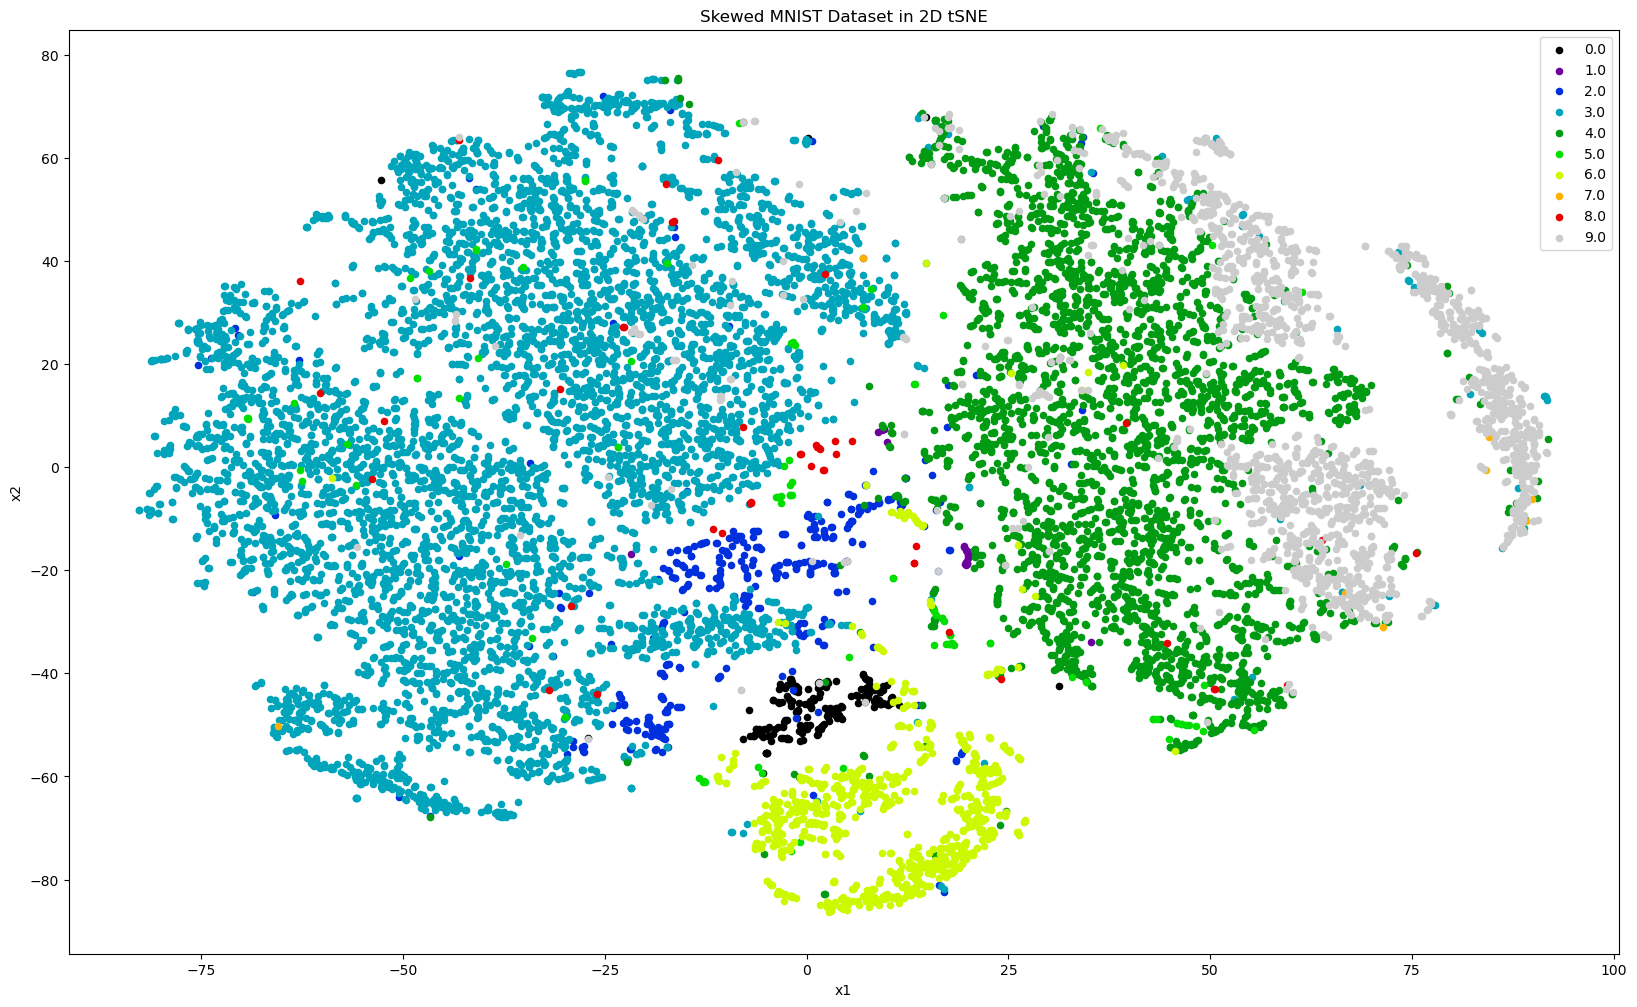

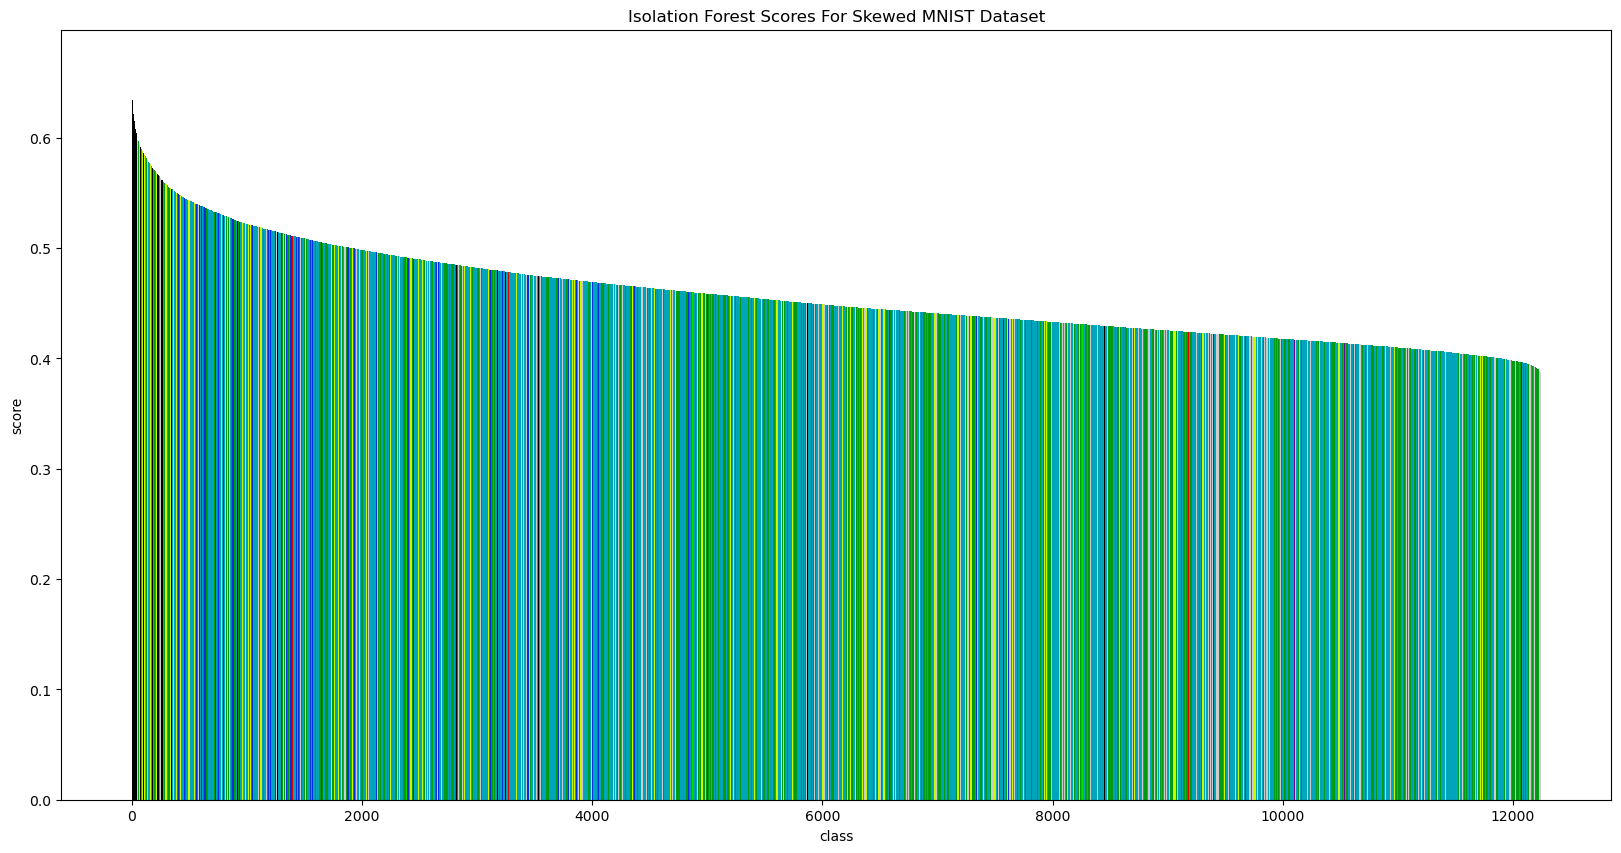

In [7]:
visualize_tsne(X_scaled, y, "Skewed MNIST Dataset in 2D tSNE")
visualize_if(X_scaled, y, "Isolation Forest Scores For Skewed MNIST Dataset")

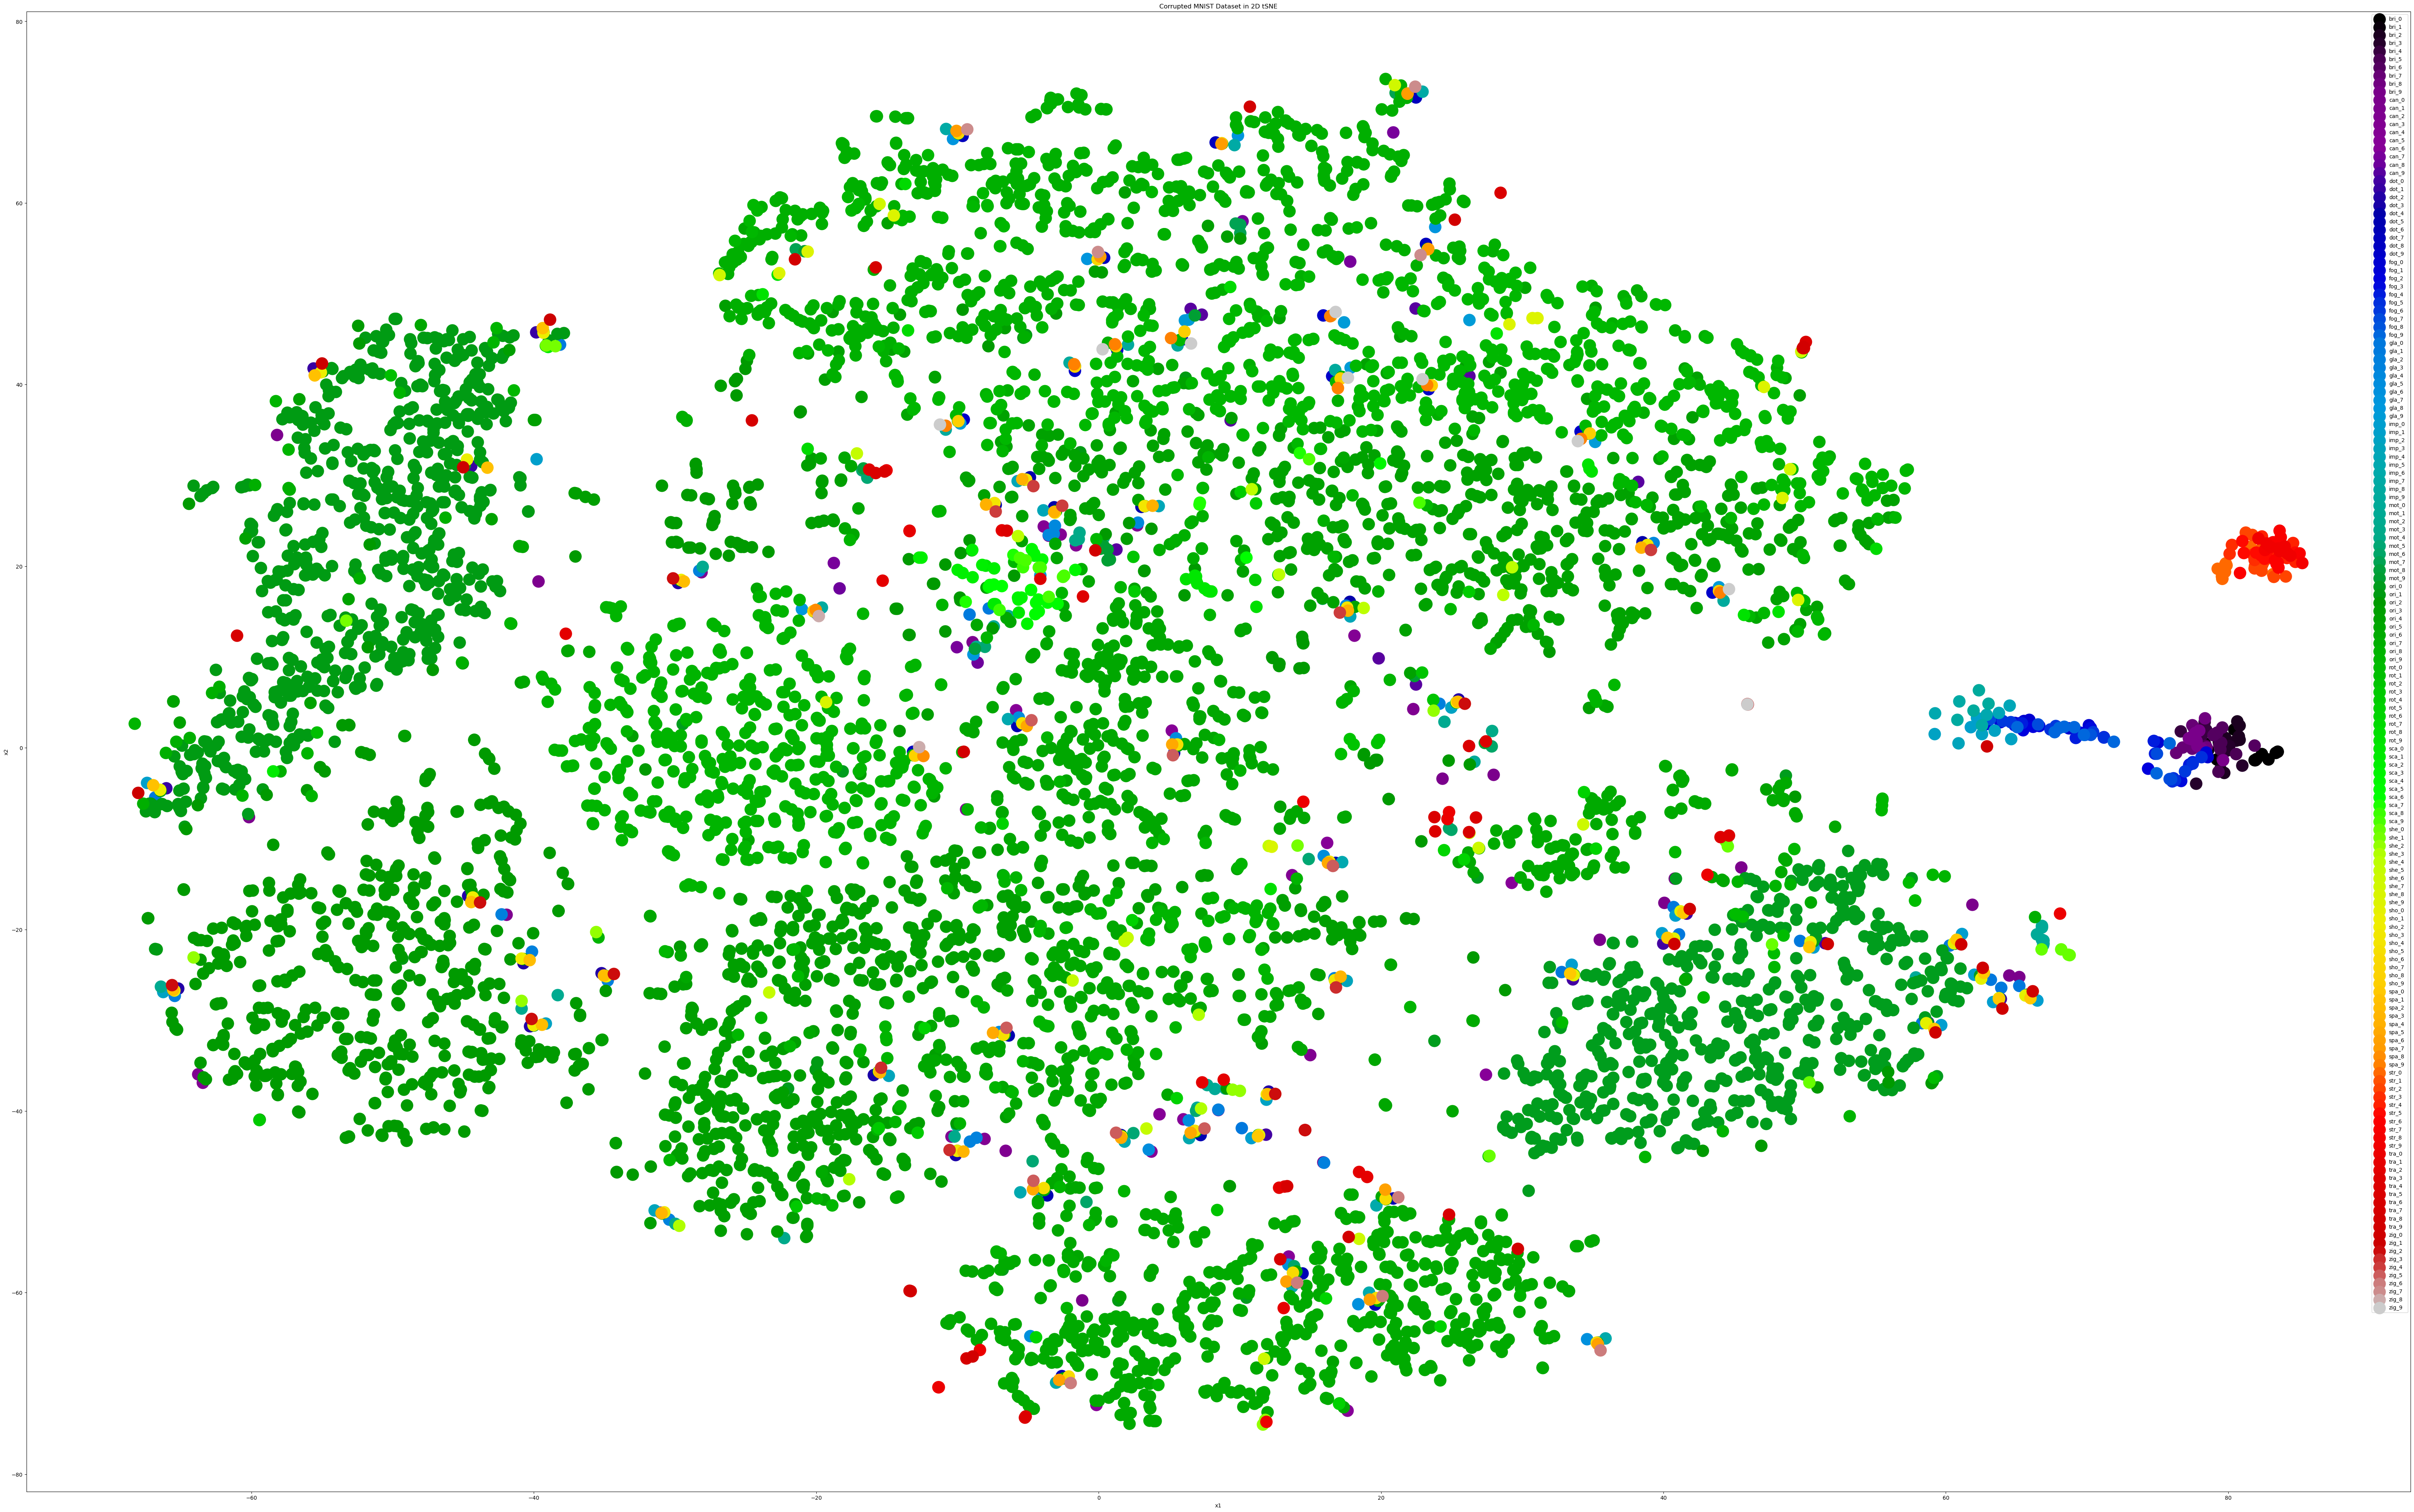

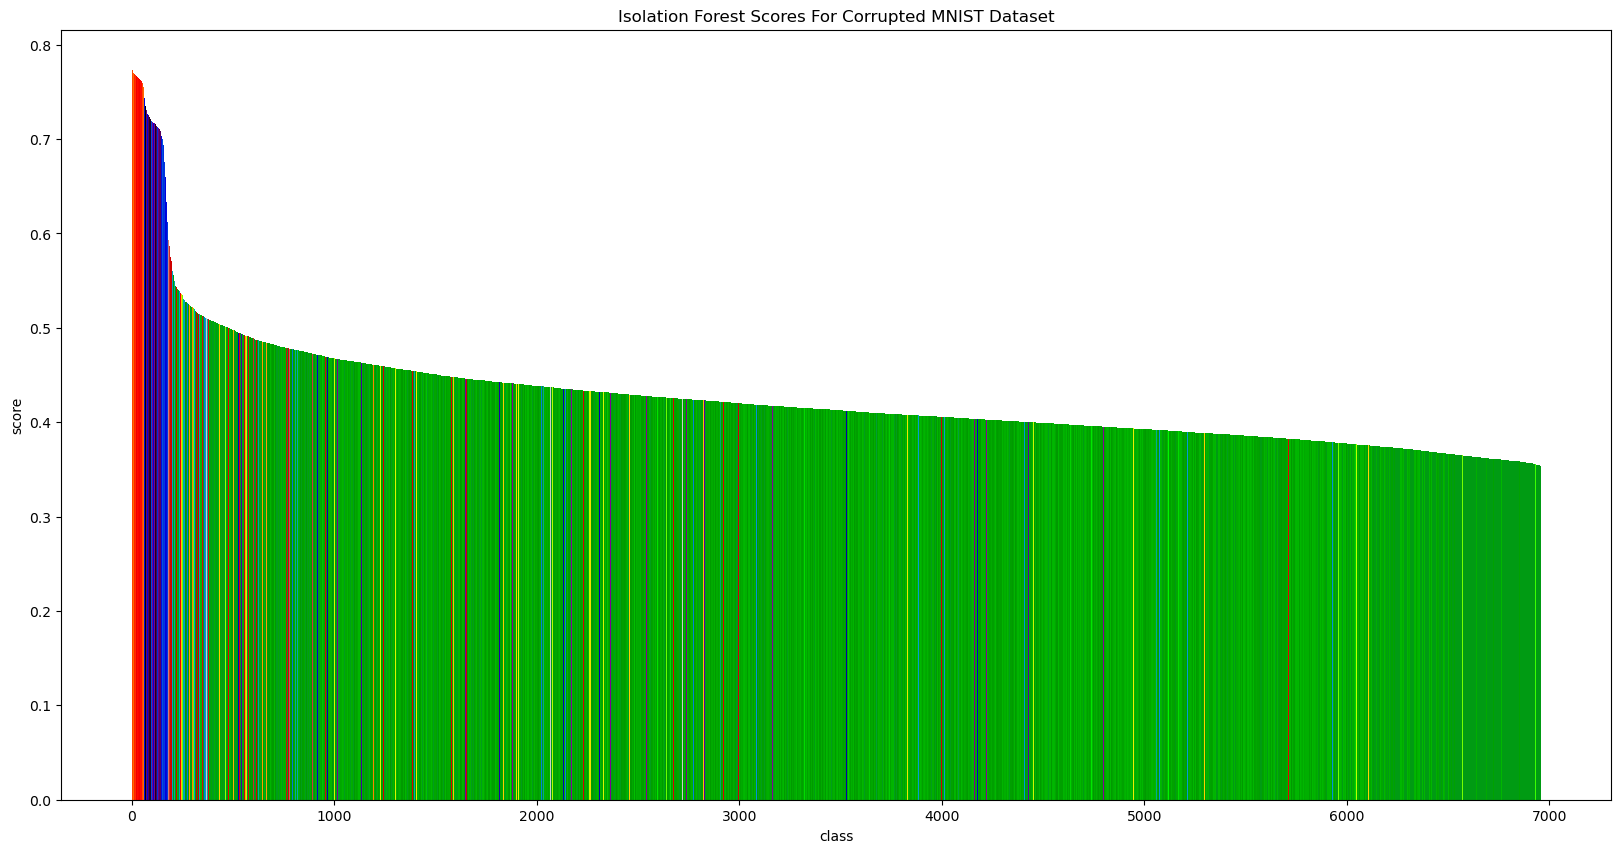

In [8]:
visualize_tsne(Xc_scaled, y_c, "Corrupted MNIST Dataset in 2D tSNE", (80, 50), 500)
visualize_if(Xc_scaled, y_c, "Isolation Forest Scores For Corrupted MNIST Dataset")

### Class Definitions

In [9]:
class Oracle:

    def __init__(self, y):
        self._y = y

    def get_label(self, index):
        return self._y[index]

### Stratergies

In [10]:
class RandomStrategy:
    def __init__(self, l):
        self._q = list(range(0,l))
        random.shuffle(self._q)

    def get_query(self):
        return self._q.pop(0)

    def process(self, _):
        return

In [11]:
class IFStrategy:
    def __init__(self, X):
        i_f = iforest(random_state=0).fit(X)
        scores = i_f.score_samples(X)
        self._q = list(np.argsort(scores))
        
    def get_query(self):
        return self._q.pop(0)

    def process(self, _):
        return

In [12]:
class LCStrategy:
    def __init__(self, X):
        self._clf = MLPClassifier(hidden_layer_sizes=(128, 32), activation='relu', solver='adam', alpha=0.0001,
                    learning_rate='constant', max_iter=1000, random_state=42)
        self._clf.fit(np.zeros((1, X.shape[1])), np.zeros((1)))
        self._ind = 0
        self._X = X
        self._X_L = np.empty((0,self._X.shape[1]))
        self._y_L = np.empty((0,))

    def get_query(self):
        probs = self._clf.predict_proba(self._X)
        self._ind = np.argmin(np.max(probs, axis=1))
        return self._ind

    def process(self, lbl):
        self._X_L = np.concatenate((self._X_L, self._X[self._ind,:].reshape((1, self._X.shape[1]))))
        self._y_L = np.concatenate((self._y_L, np.array([lbl])))
        self._clf.fit(self._X_L, self._y_L)
        return

In [13]:
class GMMStrategy:
    def __init__(self, X, num_clusters=50):
        self._q = self._make_clusters(X, num_clusters)
        self._ind = 0

    def _make_clusters(self, X, num_clusters):
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        gmm.fit(X)
        clusters = gmm.predict(X)

        cls = []
        for i in range(0, num_clusters):
            temp = [j for j in range(0, len(clusters)) if clusters[j] == i]
            cls.append(temp)

        return cls

    def get_query(self):
        index = self._q[self._ind].pop(0)
        self._ind = (self._ind + 1) % len(self._q)
        while len(self._q[self._ind]) == 0:
            self._ind = (self._ind + 1) % len(self._q)

        return index

    def process(self, lbl):
        return

In [14]:
class Node:
    def __init__(self, idx, cut, lbl=None):
        self.ind = idx
        self.cut = cut
        self.lbl = lbl
'''
add all left childs from the root
clear the queue on eaching left end
update left end
go up a node and down right
add the left child and repeat
'''
class DFSStrategy:
    def __init__(self, X, min_size, threshold):
        self._X = X
        
        self._prev_ctr = 0
        self._clf = MLPClassifier(hidden_layer_sizes=(128, 32), activation='relu', solver='adam', alpha=0.0001,
                    learning_rate='constant', max_iter=1000, random_state=42)
        self._ind = 0
        self._switch = False
        self._X_L = np.empty((0,self._X.shape[1]))
        self._y_L = np.empty((0,))
        self._threshold = threshold
        
        self._stack = []
        i_f = iforest(random_state=0).fit(X)
        scores = i_f.score_samples(X)
        self._rank = np.argsort(scores)
        self._q = [Node(0, 0)]
        self._curr_node = None
        self._min_size = min_size
        self._left = set()
        self._right = set()
        self._add_to_q(len(X)//2, len(X)//4)
        self._q_cnt = 0
        self._lbl_cnt = set()
        
    def _add_to_q(self, index, cut):
        while cut >= self._min_size:
            self._q.append(Node(index, cut))
            index = index - cut
            cut = cut // 2

    def get_query(self):
        if self._switch:
            probs = self._clf.predict_proba(self._X)
            self._ind = np.argmin(np.max(probs, axis=1))
            return self._ind
            
        if len(self._q) == 0:
            self._curr_node.ind -= 1
            return self._rank[self._curr_node.ind]
            
        self._curr_node = self._q.pop(0)
        #print(self._curr_node.ind)
        return self._rank[self._curr_node.ind]

    def process(self, lbl):
        plen = len(self._lbl_cnt)
        self._lbl_cnt.add(lbl)
        self._X_L = np.concatenate((self._X_L, self._X[self._ind,:].reshape((1, self._X.shape[1]))))
        self._y_L = np.concatenate((self._y_L, np.array([lbl])))

        if self._switch:
            self._clf._fit(self._X_L,self._y_L)
            return

        if plen == len(self._lbl_cnt):
            self._prev_ctr += 1
        else:
            self._prev_ctr = 0

        if self._prev_ctr == self._threshold:
            self._switch = True
            self._clf._fit(self._X_L,self._y_L)
        
        if self._q_cnt == 0:
            self._q_cnt += 1
            self._left.add(lbl)
            return

        self._curr_node.lbl = lbl
        
        
        if lbl in self._left or len(self._q) == 0:
            if len(self._stack) != 0:
                temp = self._stack.pop(-1)
                self._left.add(temp.lbl)
                self._q = []
                self._add_to_q(temp.ind + temp.cut, temp.cut // 2)

        elif lbl not in self._right:
            self._right.add(lbl)
            self._stack.append(self._curr_node)
            

### Active Learner Based Class Discoverer

In [15]:
class ActiveLearner:

    def __init__(self, X, strategy, oracle, mq = 400):
        self._strategy = strategy
        self._oracle = oracle
        self._X = X
        self._max_queries = mq

    def learn(self):
        
        classes = []
        uniques = []
        query_count = 0
        
        while  query_count < self._max_queries:

            query_count += 1

            indx = self._strategy.get_query()
            lbl = self._oracle.get_label(indx)
            self._strategy.process(lbl)
            
            classes.append(lbl)
            uniques.append(len(np.unique(classes)))
            
        return classes, uniques


### Testing Functions

In [16]:
def test_datasets(X, y, num_queries, title):
    
    oracle = Oracle(y)
    
    dfs_strat = DFSStrategy(X, 1, 5)
    dfs_al = ActiveLearner(X, dfs_strat, oracle, num_queries)
    dfs_cl, dfs_uc = dfs_al.learn()

    if_strat = IFStrategy(X)
    if_al = ActiveLearner(X, if_strat, oracle, num_queries)
    if_cl, if_uc = if_al.learn()

    r_strat = RandomStrategy(len(X))
    r_al = ActiveLearner(X,  r_strat, oracle, num_queries)
    r_cl, r_uc = r_al.learn()

    lc_strat = LCStrategy(X)
    lc_al = ActiveLearner(X,  lc_strat, oracle, num_queries)
    lc_cl, lc_uc = lc_al.learn()

    gmm_strat = GMMStrategy(X, len(np.unique(y)) * 2)
    gmm_al = ActiveLearner(X,  gmm_strat, oracle, num_queries)
    gmm_cl, gmm_uc = gmm_al.learn()

    ideal = list(range(1, len(np.unique(y))+1))
    
    plt.figure(figsize=(20,10))
    plt.plot(ideal, ideal, 'm--', label='Ideal Case', linewidth=2, alpha = 0.5)
    plt.plot([i for i in range(1, len(r_uc)+1)], r_uc, 'r-', label='Random / Base', linewidth=2)
    plt.plot([i for i in range(1, len(if_uc)+1)], if_uc, 'b-', label='Isolation Forest', linewidth=2)
    plt.plot([i for i in range(1, len(lc_uc)+1)], lc_uc, 'k-', label='Least Confidence', linewidth=2)
    plt.plot([i for i in range(1, len(gmm_uc)+1)], gmm_uc, 'y-', label='Gaussian Mixture Model Clustering', linewidth=2)
    plt.plot([i for i in range(1, len(dfs_uc)+1)], dfs_uc, 'g-', label='Isolation Forest + DFS + Least Confidence', linewidth=2)
    
    plt.grid()
    plt.legend()
    plt.xlabel("Number of Queries")
    plt.ylabel("Number of Classes Found")
    plt.title(title)

### Testing Skewed MNIST Dataset

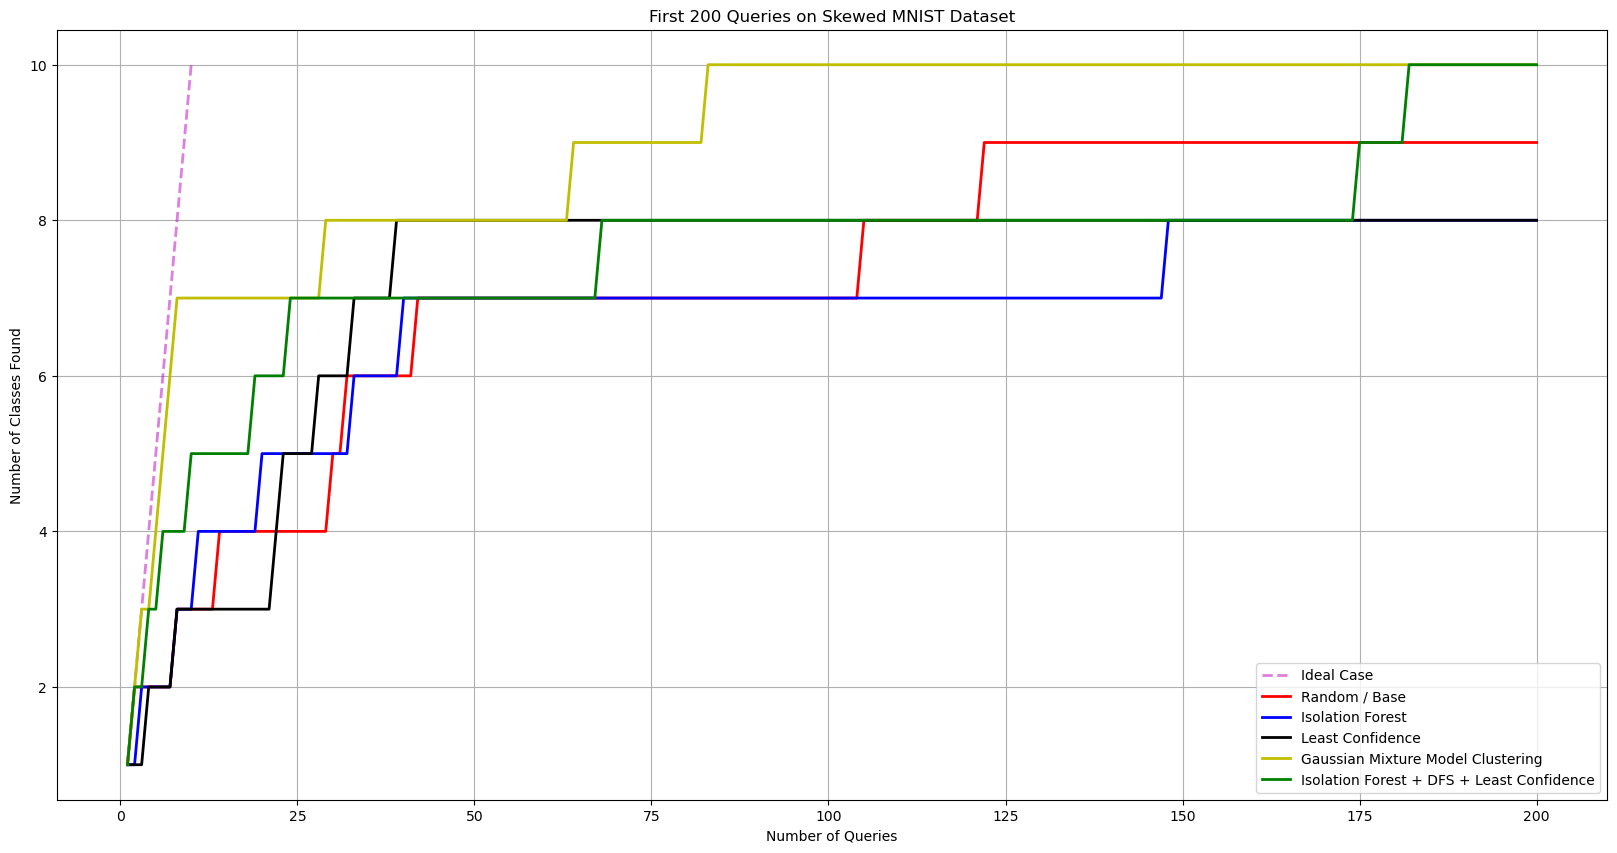

In [17]:
test_datasets(X_scaled, y, 200, "First 200 Queries on Skewed MNIST Dataset")

### Testing Corrupted MNIST Dataset

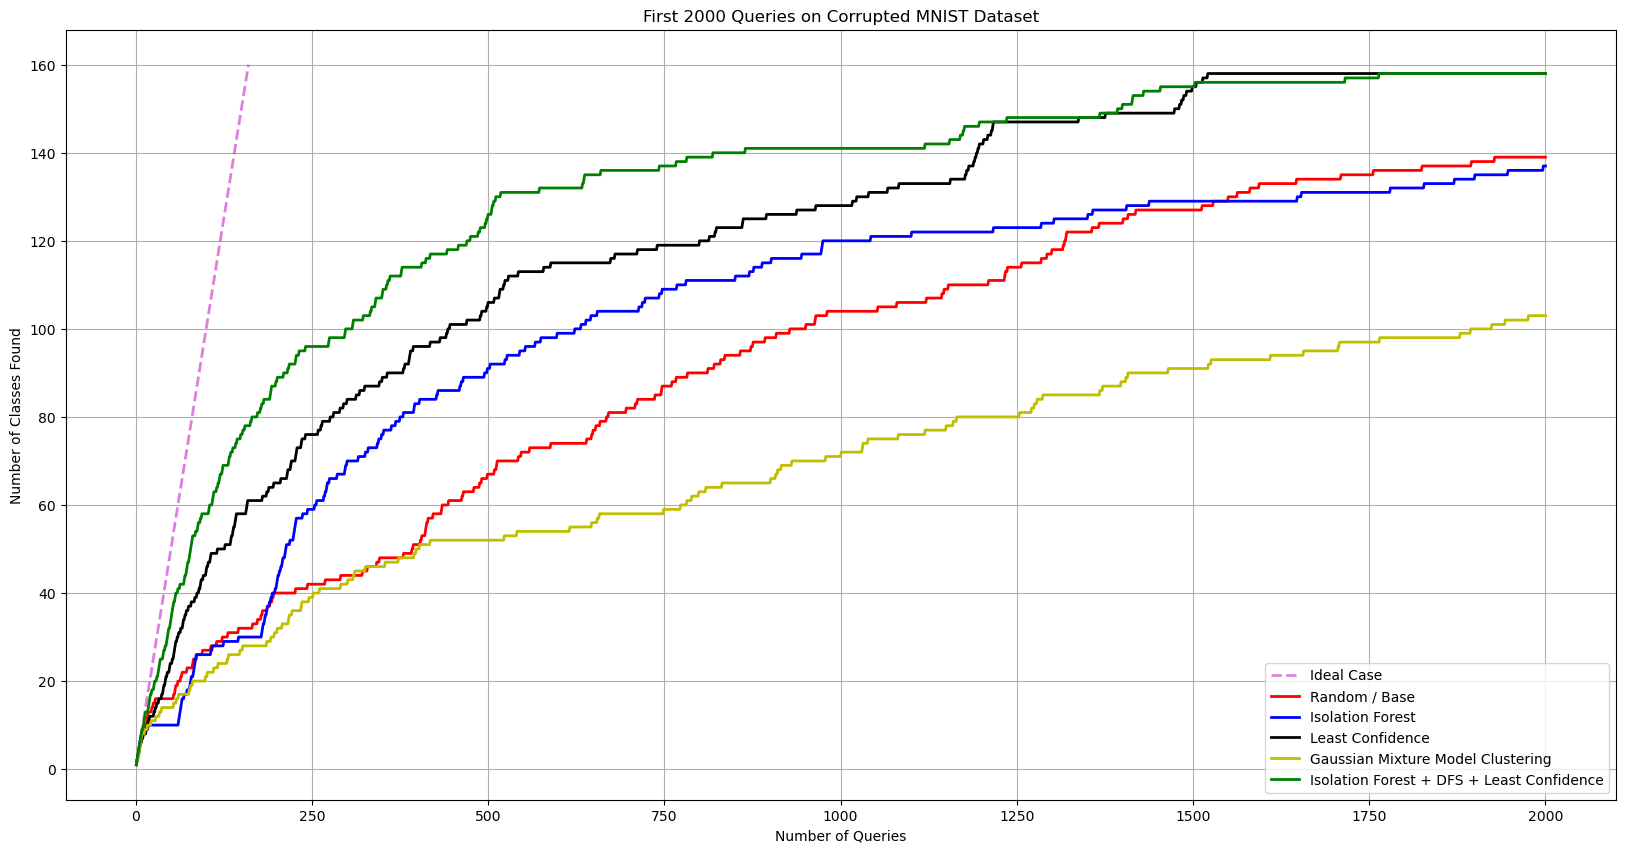

In [18]:
test_datasets(Xc_scaled, y_c, 2000, "First 2000 Queries on Corrupted MNIST Dataset")